# Exploring neighbourhoods of Staten Island of New York City to open a restaurant

## Introduction

![title](img/Staten-Island.PNG)

New York City (NYC), is the most populous city in the United States. With an estimated 2019 population of 8,336,817 distributed over about 302.6 square miles (784 km2), New York is also the most densely populated major city in the United States. The city is the center of the New York metropolitan area, the largest metropolitan area in the world by urban landmass. With almost 20 million people in its metropolitan statistical area and approximately 23 million in its combined statistical area, it is one of the world's most populous megacities.

Staten Island of New York City is the least populated of the 5 boroughs of New York City with an estimated population of 476,143 in 2019, but is the third-largest in land area at 58.5 sq mi (152 km2).

## Problem

In such a large borough with least population, finding a suitable location to open a restaurent is a daunting task. In this project, we will explore neighbourhoods of Staten Island and find which cuisines are popular in each neighbourhood, understand its demographic trends.

This analysis can be used to find a suitable neighbourhood for a restaurant. Additionally, this can also be used by a tourist travelling to Staten Island, New York City to visit neighbourhoods he/she prefers or a family looking forward to move to Staten Island, New York City and could decide which neighbourhood is best suited for them.

## Data

## To understand and explore we will need the following

1. New York City has a total of 5 boroughs and 306 neighborhoods. In order to segment the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood.

   New York City Department of City Planning published this data at https://geo.nyu.edu/catalog/nyu_2451_34572

   Data will look like below.

![title](img/NYC-data.PNG)

2. Foursquare Developers Access to venue data: https://foursquare.com/developers/apps
   
   Foursquare is a location data provider, which will be used to make RESTful API calls to retrieve data about  restaurents in different neighborhoods.
   
   Below is an example of data.

![title](img/Foursquare.PNG)

# Methodology

Download all required dependencies

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

from collections import Counter # count occurrences 

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


Dataset: https://geo.nyu.edu/catalog/nyu_2451_34572 is available in json format in file: https://cocl.us/new_york_dataset/newyork_data.json

In [2]:
import wget
import os

if os.path.exists('newyork_data.json'):
    os.remove('newyork_data.json')

wget.download('https://cocl.us/new_york_dataset/newyork_data.json')

'newyork_data.json'

Next, load the data

In [4]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

Take a quick look at the data

In [7]:
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

All the relevant data is in the features key, which is basically a list of the neighborhoods. So, define a new variable that includes this data.

In [8]:
from pprint import pprint # data pretty printer

neighborhoods_data = newyork_data['features']
pprint(neighborhoods_data[0])

{'geometry': {'coordinates': [-73.84720052054902, 40.89470517661],
              'type': 'Point'},
 'geometry_name': 'geom',
 'id': 'nyu_2451_34572.1',
 'properties': {'annoangle': 0.0,
                'annoline1': 'Wakefield',
                'annoline2': None,
                'annoline3': None,
                'bbox': [-73.84720052054902,
                         40.89470517661,
                         -73.84720052054902,
                         40.89470517661],
                'borough': 'Bronx',
                'name': 'Wakefield',
                'stacked': 1},
 'type': 'Feature'}


Tranform the data into a pandas dataframe

In [9]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
nyc_neighborhoods = pd.DataFrame(columns=column_names)

Take a look at the empty dataframe to confirm that the columns are as intended.

In [10]:
nyc_neighborhoods

,Borough,Neighborhood,Latitude,Longitude


Then loop through the data and fill the dataframe one row at a time

In [11]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lon = neighborhood_latlon[0]
    neighborhood_lat = neighborhood_latlon[1]
        
    nyc_neighborhoods = nyc_neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [12]:
nyc_neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [13]:
nyc_neighborhoods.shape

(306, 4)

In [14]:
SI_neighborhoods = nyc_neighborhoods[nyc_neighborhoods['Borough'] == 'Staten Island'].reset_index(drop=True)
SI_neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Staten Island,St. George,40.644982,-74.079353
1,Staten Island,New Brighton,40.640615,-74.087017
2,Staten Island,Stapleton,40.626928,-74.077902
3,Staten Island,Rosebank,40.615305,-74.069805
4,Staten Island,West Brighton,40.631879,-74.107182


In [15]:
SI_neighborhoods.shape

(63, 4)

Use geopy library to get the latitude and longitude values of New York City

In [16]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="nyc_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(f"The geograpical coordinates of New York City are {latitude}, {longitude}.")

The geograpical coordinates of New York City are 40.7127281, -74.0060152.


Create a map of New York City with Staten Island neighborhoods superimposed on top

In [17]:
# create map of New York City using latitude and longitude values
map_nyc = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(SI_neighborhoods['Latitude'], SI_neighborhoods['Longitude'], SI_neighborhoods['Borough'], SI_neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_nyc)  
    
map_nyc

Feel free to zoom into the above map, and click on each circle mark to reveal the name of the neighborhood and its respective borough.

Define Foursquare Credentials and Version

In [18]:
CLIENT_ID = 'EPGMBXZ5TDS4J3CTQTAXIP5DSIAMYSAPWFZ5D2DBKJQU2XR0' # your Foursquare ID
CLIENT_SECRET = 'ECFCR3CNIGXJEYCWHZ1X2L30XJOJFNW3VIULS4W3N5LBULNY' # your Foursquare Secret
VERSION = '20200409' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: EPGMBXZ5TDS4J3CTQTAXIP5DSIAMYSAPWFZ5D2DBKJQU2XR0
CLIENT_SECRET:ECFCR3CNIGXJEYCWHZ1X2L30XJOJFNW3VIULS4W3N5LBULNY


Fetch Foursquare Venue Category Hierarchy

In [19]:
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION)
category_results = requests.get(url).json()

In [20]:
pprint(category_results)

{'meta': {'code': 200, 'requestId': '5e9309d1949393001b60baad'},
 'response': {'categories': [{'categories': [{'categories': [],
                                              'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/default_',
                                                       'suffix': '.png'},
                                              'id': '56aa371be4b08b9a8d5734db',
                                              'name': 'Amphitheater',
                                              'pluralName': 'Amphitheaters',
                                              'shortName': 'Amphitheater'},
                                             {'categories': [],
                                              'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/aquarium_',
                                                       'suffix': '.png'},
                                              'id': '4fceea171983d5d06c3e9823',
     

                                                                                      'Restaurant',
                                                                              'pluralName': 'Shanghai '
                                                                                            'Restaurants',
                                                                              'shortName': 'Shanghai'},
                                                                             {'categories': [],
                                                                              'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_',
                                                                                       'suffix': '.png'},
                                                                              'id': '52af3b6e3cf9994f4e043c02',
                                                                              'name': 'Shanxi '
                        

                                                                       'suffix': '.png'},
                                                              'id': '54135bf5e4b08f3d2429dfea',
                                                              'name': 'Jain '
                                                                      'Restaurant',
                                                              'pluralName': 'Jain '
                                                                            'Restaurants',
                                                              'shortName': 'Jain'},
                                                             {'categories': [],
                                                              'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/default_',
                                                                       'suffix': '.png'},
                                                              'id': '54135bf5e4b08f3d2

                                                              'shortName': 'Baseball '
                                                                           'Field'},
                                                             {'categories': [],
                                                              'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/basketballcourt_',
                                                                       'suffix': '.png'},
                                                              'id': '4bf58dd8d48988d1e1941735',
                                                              'name': 'Basketball '
                                                                      'Court',
                                                              'pluralName': 'Basketball '
                                                                            'Courts',
                                                              'short

                                                              'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/education/cafeteria_',
                                                                       'suffix': '.png'},
                                                              'id': '54f4ba06498e2cf5561da814',
                                                              'name': 'Corporate '
                                                                      'Cafeteria',
                                                              'pluralName': 'Corporate '
                                                                            'Cafeterias',
                                                              'shortName': 'Corporate '
                                                                           'Cafeteria'},
                                                             {'categories': [],
                                                              'icon'

                                                       'suffix': '.png'},
                                              'id': '52f2ab2ebcbc57f1066b8b1e',
                                              'name': 'Locksmith',
                                              'pluralName': 'Locksmiths',
                                              'shortName': 'Locksmith'},
                                             {'categories': [],
                                              'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/financial_',
                                                       'suffix': '.png'},
                                              'id': '52f2ab2ebcbc57f1066b8b38',
                                              'name': 'Lottery Retailer',
                                              'pluralName': 'Lottery Retailers',
                                              'shortName': 'Lottery'},
                                             {'categories': [],


In [21]:
category_list = category_results['response']['categories']
pprint(category_list)

[{'categories': [{'categories': [],
                  'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/default_',
                           'suffix': '.png'},
                  'id': '56aa371be4b08b9a8d5734db',
                  'name': 'Amphitheater',
                  'pluralName': 'Amphitheaters',
                  'shortName': 'Amphitheater'},
                 {'categories': [],
                  'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/aquarium_',
                           'suffix': '.png'},
                  'id': '4fceea171983d5d06c3e9823',
                  'name': 'Aquarium',
                  'pluralName': 'Aquariums',
                  'shortName': 'Aquarium'},
                 {'categories': [],
                  'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/arcade_',
                           'suffix': '.png'},
                  'id': '4bf58dd8d48988d1e1931735',
           

                                                  'shortName': 'Henan'},
                                                 {'categories': [],
                                                  'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_',
                                                           'suffix': '.png'},
                                                  'id': '52af3add3cf9994f4e043bf5',
                                                  'name': 'Hong Kong '
                                                          'Restaurant',
                                                  'pluralName': 'Hong Kong '
                                                                'Restaurants',
                                                  'shortName': 'Hong Kong'},
                                                 {'categories': [],
                                                  'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_',
       

                  'id': '4bf58dd8d48988d112941735',
                  'name': 'Juice Bar',
                  'pluralName': 'Juice Bars',
                  'shortName': 'Juice Bar'},
                 {'categories': [],
                  'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/middleeastern_',
                           'suffix': '.png'},
                  'id': '5283c7b4e4b094cb91ec88d7',
                  'name': 'Kebab Restaurant',
                  'pluralName': 'Kebab Restaurants',
                  'shortName': 'Kebab'},
                 {'categories': [{'categories': [],
                                  'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/arepas_',
                                           'suffix': '.png'},
                                  'id': '4bf58dd8d48988d152941735',
                                  'name': 'Arepa Restaurant',
                                  'pluralName': 'Arepa Restaurants',
                        

                  'name': 'Farm',
                  'pluralName': 'Farms',
                  'shortName': 'Farm'},
                 {'categories': [],
                  'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/field_',
                           'suffix': '.png'},
                  'id': '4bf58dd8d48988d15f941735',
                  'name': 'Field',
                  'pluralName': 'Fields',
                  'shortName': 'Field'},
                 {'categories': [],
                  'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/food_fishmarket_',
                           'suffix': '.png'},
                  'id': '52e81612bcbc57f1066b7a0f',
                  'name': 'Fishing Spot',
                  'pluralName': 'Fishing Spots',
                  'shortName': 'Fishing Spot'},
                 {'categories': [],
                  'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/default_',
                  

                  'name': 'Antique Shop',
                  'pluralName': 'Antique Shops',
                  'shortName': 'Antiques'},
                 {'categories': [],
                  'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/artstore_',
                           'suffix': '.png'},
                  'id': '4bf58dd8d48988d127951735',
                  'name': 'Arts & Crafts Store',
                  'pluralName': 'Arts & Crafts Stores',
                  'shortName': 'Arts & Crafts'},
                 {'categories': [],
                  'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/default_',
                           'suffix': '.png'},
                  'id': '52f2ab2ebcbc57f1066b8b43',
                  'name': 'Astrologer',
                  'pluralName': 'Astrologers',
                  'shortName': 'Astrologer'},
                 {'categories': [{'categories': [],
                                  'icon': {'prefix': 'https://ss3.4sq

                                  'pluralName': 'Airport Lounges',
                                  'shortName': 'Lounge'},
                                 {'categories': [],
                                  'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/airport_',
                                           'suffix': '.png'},
                                  'id': '56aa371be4b08b9a8d57352f',
                                  'name': 'Airport Service',
                                  'pluralName': 'Airport Services',
                                  'shortName': 'Airport Service'},
                                 {'categories': [],
                                  'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/airport_gate_',
                                           'suffix': '.png'},
                                  'id': '4bf58dd8d48988d1eb931735',
                                  'name': 'Airport Terminal',
                          

In [22]:
for data in category_list:
    print(data['id'], data['name'])

4d4b7104d754a06370d81259 Arts & Entertainment
4d4b7105d754a06372d81259 College & University
4d4b7105d754a06373d81259 Event
4d4b7105d754a06374d81259 Food
4d4b7105d754a06376d81259 Nightlife Spot
4d4b7105d754a06377d81259 Outdoors & Recreation
4d4b7105d754a06375d81259 Professional & Other Places
4e67e38e036454776db1fb3a Residence
4d4b7105d754a06378d81259 Shop & Service
4d4b7105d754a06379d81259 Travel & Transport


Note that food id is '4d4b7105d754a06374d81259'

In [23]:
# function to flatten a 'parent_id' category, returns all categories if checkParentID = False
def flatten_Hierarchy(category_list, checkParentID, category_dict, parent_id = ''):
    for data in category_list:
        
        if checkParentID == True and data['id'] == parent_id:
            category_dict[data['id']] = data['name']
            flatten_Hierarchy(category_list = data['categories'], checkParentID = False, category_dict = category_dict)
        
        elif checkParentID == False:
            category_dict[data['id']] = data['name']
            if len(data['categories']) != 0:
                flatten_Hierarchy(category_list = data['categories'], checkParentID = False, category_dict = category_dict)
    
    return category_dict

In [24]:
# this function takes the parent ID and returns 'name' and 'id' of all the sub-categories
category_dict = flatten_Hierarchy(category_list, checkParentID=True, category_dict = {}, parent_id = '4d4b7105d754a06374d81259')

pprint(category_dict)

{'4bf58dd8d48988d107941735': 'Argentinian Restaurant',
 '4bf58dd8d48988d108941735': 'Dumpling Restaurant',
 '4bf58dd8d48988d109941735': 'Eastern European Restaurant',
 '4bf58dd8d48988d10a941735': 'Ethiopian Restaurant',
 '4bf58dd8d48988d10b941735': 'Falafel Restaurant',
 '4bf58dd8d48988d10c941735': 'French Restaurant',
 '4bf58dd8d48988d10d941735': 'German Restaurant',
 '4bf58dd8d48988d10e941735': 'Greek Restaurant',
 '4bf58dd8d48988d10f941735': 'Indian Restaurant',
 '4bf58dd8d48988d110941735': 'Italian Restaurant',
 '4bf58dd8d48988d111941735': 'Japanese Restaurant',
 '4bf58dd8d48988d112941735': 'Juice Bar',
 '4bf58dd8d48988d113941735': 'Korean Restaurant',
 '4bf58dd8d48988d115941735': 'Middle Eastern Restaurant',
 '4bf58dd8d48988d120951735': 'Food Court',
 '4bf58dd8d48988d128941735': 'Cafeteria',
 '4bf58dd8d48988d142941735': 'Asian Restaurant',
 '4bf58dd8d48988d143941735': 'Breakfast Spot',
 '4bf58dd8d48988d144941735': 'Caribbean Restaurant',
 '4bf58dd8d48988d145941735': 'Chinese Resta

Now, we have all the categories in Food with their id's.

Explore the first neighborhood of Staten Island to understand the results of GET Request

Get the neighborhood's name.

In [25]:
SI_neighborhoods.loc[0, 'Neighborhood']

'St. George'

Get the neighborhood's latitude and longitude values.

In [26]:
neighborhood_latitude = SI_neighborhoods.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = SI_neighborhoods.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = SI_neighborhoods.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of St. George are 40.6449815710044, -74.07935312512797.


Now, let's get the Food that is in St. George within a radius of 400 meters.

First, let's create the GET request URL to search for Venue with requested Category ID

In [27]:
LIMIT = 1 # limit of number of venues returned by Foursquare API
radius = 400 # define radius
categoryId = '4d4b7105d754a06374d81259' # category ID for "Food"

# create URL

url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius,
    categoryId,
    LIMIT)

results = requests.get(url).json()
pprint(results)

{'meta': {'code': 200, 'requestId': '5e9309df60ba08001b63e5ec'},
 'response': {'confident': False,
              'venues': [{'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/deli_',
                                                   'suffix': '.png'},
                                          'id': '4bf58dd8d48988d146941735',
                                          'name': 'Deli / Bodega',
                                          'pluralName': 'Delis / Bodegas',
                                          'primary': True,
                                          'shortName': 'Deli / Bodega'}],
                          'hasPerk': False,
                          'id': '4d41997c255d8cfac9ed7105',
                          'location': {'address': '19 Fort Pl',
                                       'cc': 'US',
                                       'city': 'New York',
                                       'country': 'United States',
                     

In [28]:
pprint(results['response']['venues'])

[{'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/deli_',
                           'suffix': '.png'},
                  'id': '4bf58dd8d48988d146941735',
                  'name': 'Deli / Bodega',
                  'pluralName': 'Delis / Bodegas',
                  'primary': True,
                  'shortName': 'Deli / Bodega'}],
  'hasPerk': False,
  'id': '4d41997c255d8cfac9ed7105',
  'location': {'address': '19 Fort Pl',
               'cc': 'US',
               'city': 'New York',
               'country': 'United States',
               'crossStreet': 'at Belmont Pl',
               'distance': 325,
               'formattedAddress': ['19 Fort Pl (at Belmont Pl)',
                                    'New York, NY 10301',
                                    'United States'],
               'labeledLatLngs': [{'label': 'display',
                                   'lat': 40.6420670896968,
                                   'lng': -74.07902687788008

Name of the food category is 'Deli / Bodega'

Create a function to repeat the above process to all the neighborhoods of Staten Island

In [29]:
def getNearbyFood(names, latitudes, longitudes, radius=400, LIMIT=100):
    not_found = 0
    print('***Start ', end='')
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(' .', end='')
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            "4d4b7105d754a06374d81259", # "Food" category id
            LIMIT)
            
        try:
            # make the GET request
            results = requests.get(url).json()['response']['venues']
            
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['name'], 
                v['location']['lat'], 
                v['location']['lng'],  
                v['categories'][0]['name']) for v in results])
        except:
            not_found += 1


    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    print(f"{not_found} venues with incompelete information.")
    return(nearby_venues)

To counter any redundant requests to the Foursquare API, use pickle to serialize the information retrieved from GET requests.

In [30]:
import pickle # to serialize and deserialize a Python object structure
try:
    with open('SI_food_venues.pkl', 'rb') as f:
        SI_venues = pickle.load(f)
    print("---Dataframe Existed and Deserialized---")
except:
    SI_venues = getNearbyFood(names=SI_neighborhoods['Neighborhood'],
                              latitudes=SI_neighborhoods['Latitude'],
                              longitudes=SI_neighborhoods['Longitude'])
    
    with open('SI_food_venues.pkl', 'wb') as f:
        pickle.dump(SI_venues, f)
    print("---Dataframe Created and Serialized---")

---Dataframe Existed and Deserialized---


In [31]:
SI_venues.shape

(925, 7)

In [32]:
SI_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,St. George,40.644982,-74.079353,Charmar Superrette,40.643971,-74.077482,Deli / Bodega
1,St. George,40.644982,-74.079353,Chang Noi Thai,40.643692,-74.077957,Thai Restaurant
2,St. George,40.644982,-74.079353,A&S Pizzeria,40.643940,-74.077626,Pizza Place
3,St. George,40.644982,-74.079353,The Burrito Shoppe,40.643639,-74.077919,Fast Food Restaurant
4,St. George,40.644982,-74.079353,The Salad Junkie,40.643868,-74.077656,Salad Place


Find how many unique categories can be curated from all the returned venues

In [33]:
print(f"There are {len(SI_venues['Venue Category'].unique())} uniques categories.")
SI_venues.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False)

There are 92 uniques categories.


Venue Category
Deli / Bodega                               126
Pizza Place                                 114
Italian Restaurant                           70
Chinese Restaurant                           41
Bagel Shop                                   41
Bakery                                       34
Mexican Restaurant                           33
Ice Cream Shop                               32
American Restaurant                          32
Food                                         31
Sandwich Place                               26
Café                                         23
Coffee Shop                                  22
Restaurant                                   21
Donut Shop                                   17
Sushi Restaurant                             16
Fast Food Restaurant                         15
Food Truck                                   12
Diner                                        12
Spanish Restaurant                           11
BBQ Joint                

Remove the generalized categories, like Restaurent, Food.

In [34]:
unique_categories = SI_venues['Venue Category'].unique().tolist()

# manually create a list of generalized categories
general_categories = ['Food','Café','Coffee Shop','Restaurant','Rock Club','Residential Building (Apartment / Condo)'
                      ,'Poke Place','Garden','Gym / Fitness Center','Other Nightlife','Irish Pub','Grocery Store'
                      ,'Snack Place','Event Space','Tea Room','Creperie','Cafeteria','Butcher','Dessert Shop','Juice Bar'
                      ,'Breakfast Spot','Bubble Tea Shop','Gastropub','Hookah Bar','Soup Place','Bar','Convenience Store'
                      ,'Smoothie Shop','']

food_categories =  list(set(unique_categories) - set(general_categories))

food_categories

['Food Truck',
 'Indian Restaurant',
 'Spanish Restaurant',
 'Dim Sum Restaurant',
 'African Restaurant',
 'Fried Chicken Joint',
 'Tapas Restaurant',
 'Korean Restaurant',
 'New American Restaurant',
 'Burrito Place',
 'Gourmet Shop',
 'Tex-Mex Restaurant',
 'Cajun / Creole Restaurant',
 'Deli / Bodega',
 'Mediterranean Restaurant',
 'Salad Place',
 'Frozen Yogurt Shop',
 'Bakery',
 'Southern / Soul Food Restaurant',
 'Jewish Restaurant',
 'Fast Food Restaurant',
 'Halal Restaurant',
 'German Restaurant',
 'Bistro',
 'Falafel Restaurant',
 'Mac & Cheese Joint',
 'Burger Joint',
 'Filipino Restaurant',
 'French Restaurant',
 'Latin American Restaurant',
 'BBQ Joint',
 'Fish & Chips Shop',
 'American Restaurant',
 'Mexican Restaurant',
 'Middle Eastern Restaurant',
 'Theme Restaurant',
 'Sandwich Place',
 'Steakhouse',
 'Sushi Restaurant',
 'Wings Joint',
 'Vietnamese Restaurant',
 'Chinese Restaurant',
 'Donut Shop',
 'Bagel Shop',
 'Sri Lankan Restaurant',
 'Caribbean Restaurant',
 'T

In [35]:
SI_venues = SI_venues[SI_venues['Venue Category'].isin(food_categories)].reset_index()
print(SI_venues.shape)
SI_venues.head(5)

(774, 8)


,index,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,St. George,40.644982,-74.079353,Charmar Superrette,40.643971,-74.077482,Deli / Bodega
1,1,St. George,40.644982,-74.079353,Chang Noi Thai,40.643692,-74.077957,Thai Restaurant
2,2,St. George,40.644982,-74.079353,A&S Pizzeria,40.643940,-74.077626,Pizza Place
3,3,St. George,40.644982,-74.079353,The Burrito Shoppe,40.643639,-74.077919,Fast Food Restaurant
4,4,St. George,40.644982,-74.079353,The Salad Junkie,40.643868,-74.077656,Salad Place


Analyze Each Neighborhood

In [36]:
# one hot encoding
SI_onehot = pd.get_dummies(SI_venues[['Venue Category']], prefix="", prefix_sep="")
SI_onehot.head()

,African Restaurant,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Burger Joint,Burrito Place,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Donut Shop,Eastern European Restaurant,Empanada Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,German Restaurant,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Halal Restaurant,Hot Dog Joint,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Korean Restaurant,Latin American Restaurant,Mac & Cheese Joint,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,New American Restaurant,Peruvian Restaurant,Pizza Place,Salad Place,Sandwich Place,Seafood Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [37]:
# add neighborhood column back to dataframe
SI_onehot['Neighborhood'] = SI_venues['Neighborhood'] 
SI_onehot.head()

,African Restaurant,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Burger Joint,Burrito Place,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Donut Shop,Eastern European Restaurant,Empanada Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,German Restaurant,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Halal Restaurant,Hot Dog Joint,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Korean Restaurant,Latin American Restaurant,Mac & Cheese Joint,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,New American Restaurant,Peruvian Restaurant,Pizza Place,Salad Place,Sandwich Place,Seafood Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint,Neighborhood
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,St. George
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,St. George
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,St. George
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,St. George
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,St. George


In [38]:
# move neighborhood column to the first column
neighborhood = SI_onehot['Neighborhood']

SI_onehot.drop(labels=['Neighborhood'], axis=1,inplace = True)
SI_onehot.insert(0, 'Neighborhood', neighborhood)

SI_onehot.head()

,Neighborhood,African Restaurant,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Burger Joint,Burrito Place,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Donut Shop,Eastern European Restaurant,Empanada Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,German Restaurant,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Halal Restaurant,Hot Dog Joint,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Korean Restaurant,Latin American Restaurant,Mac & Cheese Joint,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,New American Restaurant,Peruvian Restaurant,Pizza Place,Salad Place,Sandwich Place,Seafood Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,St. George,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,St. George,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,St. George,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,St. George,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,St. George,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [41]:
# count venues of each category in each neighborhood

venue_counts = SI_onehot.groupby('Neighborhood').sum()
venue_counts.head(5)

,African Restaurant,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Burger Joint,Burrito Place,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Donut Shop,Eastern European Restaurant,Empanada Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,German Restaurant,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Halal Restaurant,Hot Dog Joint,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Korean Restaurant,Latin American Restaurant,Mac & Cheese Joint,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,New American Restaurant,Peruvian Restaurant,Pizza Place,Salad Place,Sandwich Place,Seafood Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
Neighborhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Annadale,0,3,0,0,1,2,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
Arden Heights,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Arlington,0,2,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Arrochar,0,0,0,0,2,0,0,0,0,0,0,1,0,4,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,1,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Bay Terrace,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


Find the top 10 food categories in Staten Island, NYC

In [42]:
venue_counts_described = venue_counts.describe().transpose()

venue_top10 = venue_counts_described.sort_values('max', ascending=False)[0:10]
venue_top10

,count,mean,std,min,25%,50%,75%,max
Deli / Bodega,59.0,2.135593,2.452709,0.0,0.0,2.0,3.0,11.0
Pizza Place,59.0,1.932203,2.116148,0.0,0.0,1.0,3.0,8.0
Mexican Restaurant,59.0,0.559322,1.207322,0.0,0.0,0.0,1.0,5.0
Italian Restaurant,59.0,1.186441,1.444067,0.0,0.0,1.0,2.0,5.0
Chinese Restaurant,59.0,0.694915,1.070840,0.0,0.0,0.0,1.0,5.0
Asian Restaurant,59.0,0.152542,0.638251,0.0,0.0,0.0,0.0,4.0
Bagel Shop,59.0,0.694915,0.933186,0.0,0.0,0.0,1.0,4.0
Bakery,59.0,0.576271,0.968529,0.0,0.0,0.0,1.0,4.0
American Restaurant,59.0,0.542373,0.837114,0.0,0.0,0.0,1.0,4.0
Food Truck,59.0,0.203390,0.550224,0.0,0.0,0.0,0.0,3.0


Plot the top 10 food categories

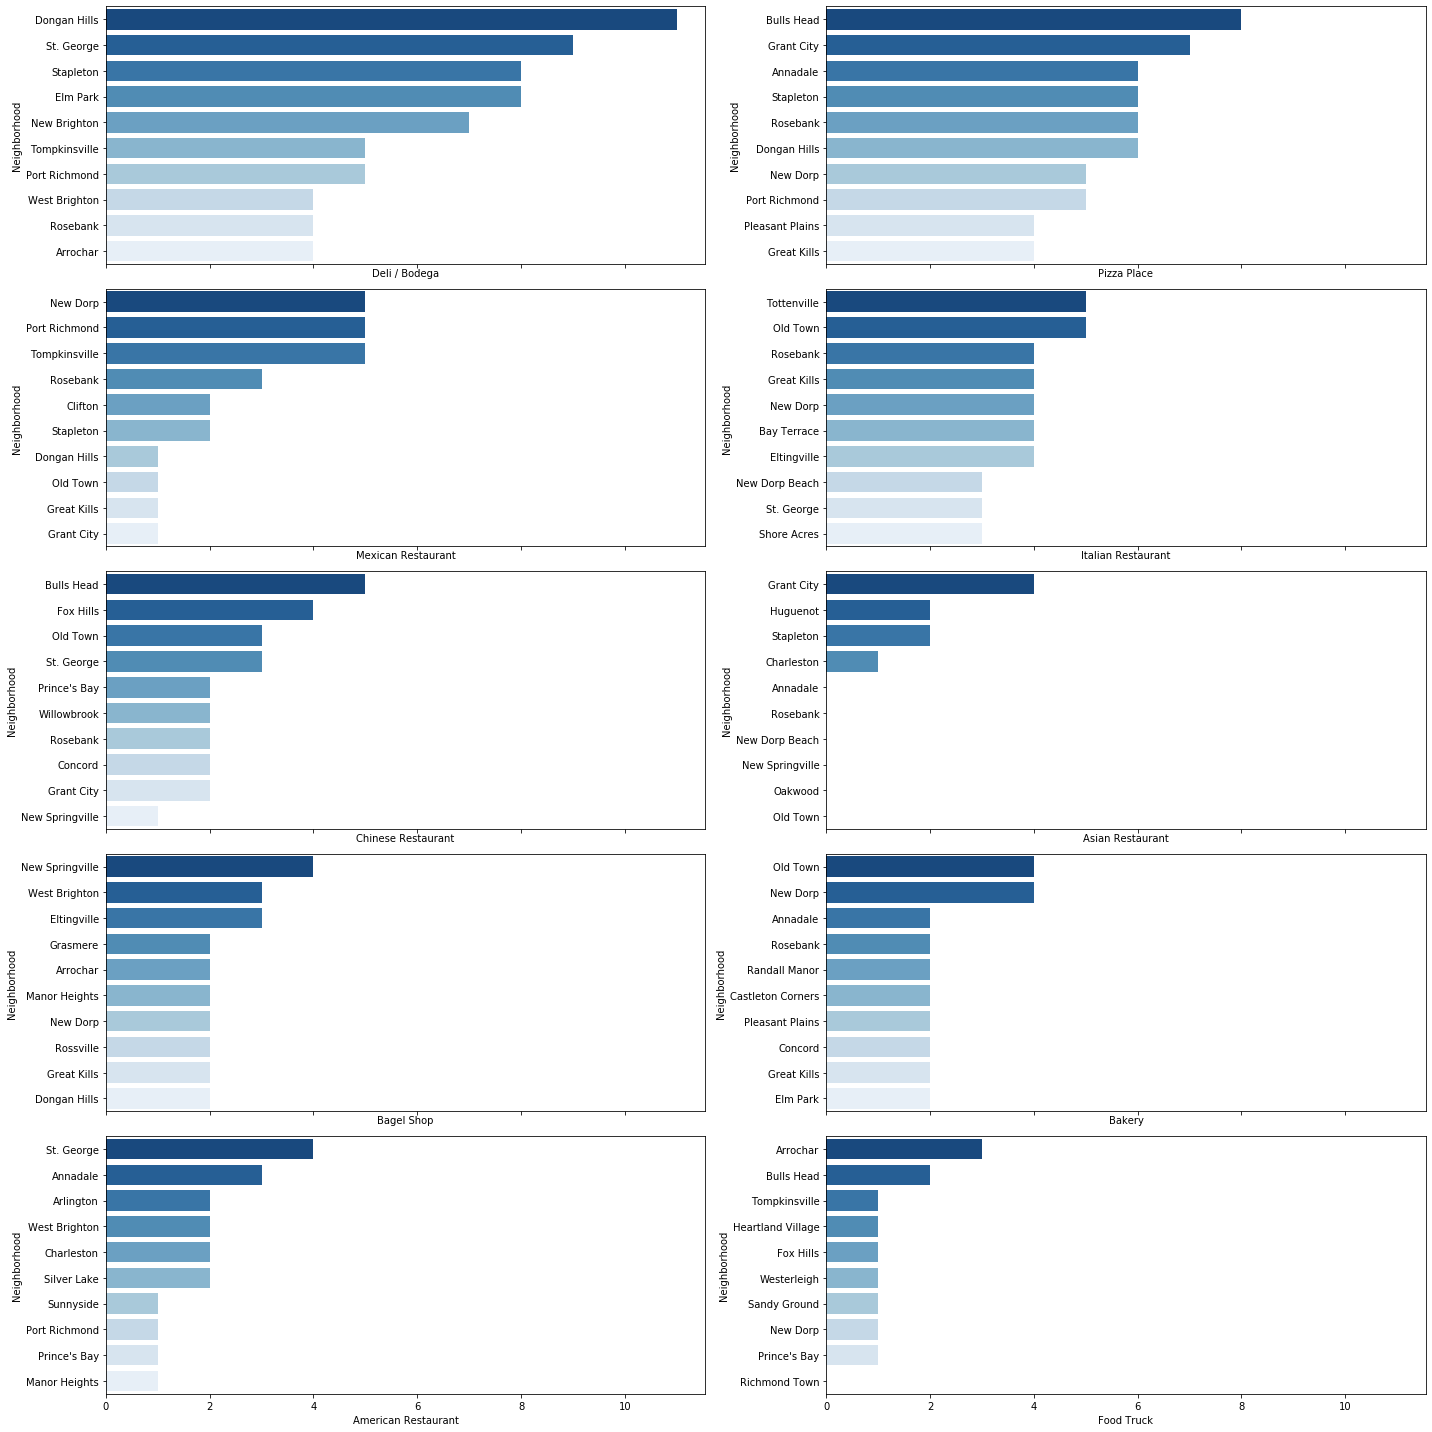

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

venue_top10_list = venue_top10.index.values.tolist()

fig, axes =plt.subplots(5, 2, figsize=(20,20), sharex=True)
axes = axes.flatten()

for ax, category in zip(axes, venue_top10_list):
    data = venue_counts[[category]].sort_values([category], ascending=False)[0:10]
    pal = sns.color_palette("Blues", len(data))
    sns.barplot(x=category, y=data.index, data=data, ax=ax, palette=np.array(pal[::-1]))

plt.tight_layout()
plt.show();

Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [44]:
SI_grouped = SI_onehot.groupby('Neighborhood').mean().reset_index()
SI_grouped.head()

,Neighborhood,African Restaurant,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Burger Joint,Burrito Place,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Donut Shop,Eastern European Restaurant,Empanada Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,German Restaurant,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Halal Restaurant,Hot Dog Joint,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Korean Restaurant,Latin American Restaurant,Mac & Cheese Joint,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,New American Restaurant,Peruvian Restaurant,Pizza Place,Salad Place,Sandwich Place,Seafood Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Annadale,0.0,0.200000,0.0,0.0,0.066667,0.133333,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.066667,0.0,0.066667,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.400000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Arden Heights,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.500000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Arlington,0.0,0.333333,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.166667,0.000000,0.0,0.166667,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.166667,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Arrochar,0.0,0.000000,0.0,0.0,0.111111,0.000000,0.0,0.0,0.0,0.0,0.000000,0.055556,0.0,0.222222,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.055556,0.0,0.055556,0.0,0.000000,0.222222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Bay Terrace,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.111111,0.0,0.000000,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.444444,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
# function to sort venues in descending order

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create the new dataframe and display the top 5 venues for each neighborhood.

In [46]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))    

In [47]:
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = SI_grouped['Neighborhood']

for ind in np.arange(SI_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(SI_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Annadale,Pizza Place,American Restaurant,Bakery,Diner,Bagel Shop
1,Arden Heights,Pizza Place,Deli / Bodega,Wings Joint,Gluten-free Restaurant,German Restaurant
2,Arlington,American Restaurant,Peruvian Restaurant,Pizza Place,Deli / Bodega,Caribbean Restaurant
3,Arrochar,Pizza Place,Deli / Bodega,Food Truck,Italian Restaurant,Bagel Shop
4,Bay Terrace,Italian Restaurant,Sushi Restaurant,Donut Shop,Deli / Bodega,French Restaurant


## Cluster Neighborhoods

Run k-means to count Neighborhoods for each cluster label for variable cluster size

In [48]:
SI_grouped_clustering = SI_grouped.drop('Neighborhood', 1)


Determine the optimal number of clusters for k-means clustering

The Elbow Method - calculate the sum of squared distances of samples to their closest cluster center for different values of k. The value of k after which there is no siginificant decrease in sum of squared distances is choosen.

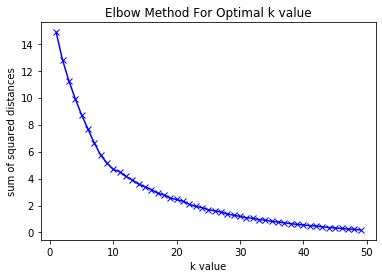

In [49]:
sum_of_squared_distances = []
K = range(1,50)
for k in K:
    kmeans = KMeans(n_clusters=k).fit(SI_grouped_clustering)
    sum_of_squared_distances.append(kmeans.inertia_)

plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k value')
plt.ylabel('sum of squared distances')
plt.title('Elbow Method For Optimal k value');

There seems to be a slight bend at 9, but confirm this with Silhouette Method. 

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

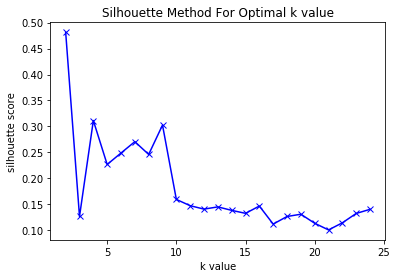

In [51]:
from sklearn.metrics import silhouette_score

sil = []
K_sil = range(2,25) # minimum 2 clusters required, to define dissimilarity

for k in K_sil:
    print(k, end=' ')
    kmeans = KMeans(n_clusters = k).fit(SI_grouped_clustering)
    labels = kmeans.labels_
    sil.append(silhouette_score(SI_grouped_clustering, labels, metric = 'euclidean'))

plt.plot(K_sil, sil, 'bx-')
plt.xlabel('k value')
plt.ylabel('silhouette score')
plt.title('Silhouette Method For Optimal k value')
plt.show()

There is a peak at k = 2,4,6 & 9. Since Elbow method also gave a result of 9 as best value, use 9 clusters

In [78]:
kclusters = 9

# run k-means clustering
kmeans = KMeans(init="k-means++", n_clusters=kclusters, n_init=25).fit(SI_grouped_clustering)

print(Counter(kmeans.labels_))

Counter({5: 24, 8: 18, 1: 6, 3: 3, 4: 2, 7: 2, 0: 2, 2: 1, 6: 1})


Create a new dataframe that includes the cluster as well as the top 5 venues for each neighborhood.

In [79]:
# add clustering labels
try:
    neighborhoods_venues_sorted.drop('Cluster Labels', axis=1)
except:
    neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

neighborhoods_venues_sorted.head(5)

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,5,Annadale,Pizza Place,American Restaurant,Bakery,Diner,Bagel Shop
1,8,Arden Heights,Pizza Place,Deli / Bodega,Wings Joint,Gluten-free Restaurant,German Restaurant
2,8,Arlington,American Restaurant,Peruvian Restaurant,Pizza Place,Deli / Bodega,Caribbean Restaurant
3,8,Arrochar,Pizza Place,Deli / Bodega,Food Truck,Italian Restaurant,Bagel Shop
4,1,Bay Terrace,Italian Restaurant,Sushi Restaurant,Donut Shop,Deli / Bodega,French Restaurant


In [80]:
# merge neighborhoods_venues_sorted with SI_data to add latitude/longitude for each neighborhood
SI_merged = neighborhoods_venues_sorted.join(SI_neighborhoods.set_index('Neighborhood'), on='Neighborhood')
SI_merged.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
0,5,Annadale,Pizza Place,American Restaurant,Bakery,Diner,Bagel Shop,Staten Island,40.538114,-74.178549
1,8,Arden Heights,Pizza Place,Deli / Bodega,Wings Joint,Gluten-free Restaurant,German Restaurant,Staten Island,40.549286,-74.185887
2,8,Arlington,American Restaurant,Peruvian Restaurant,Pizza Place,Deli / Bodega,Caribbean Restaurant,Staten Island,40.635325,-74.165104
3,8,Arrochar,Pizza Place,Deli / Bodega,Food Truck,Italian Restaurant,Bagel Shop,Staten Island,40.596313,-74.067124
4,1,Bay Terrace,Italian Restaurant,Sushi Restaurant,Donut Shop,Deli / Bodega,French Restaurant,Staten Island,40.553988,-74.139166


Visualize the resulting clusters

In [81]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(SI_merged['Latitude'], SI_merged['Longitude'], SI_merged['Neighborhood'], SI_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Results

### Cluster 0

In [82]:
cluster_0 = SI_merged.loc[SI_merged['Cluster Labels'] == 0, SI_merged.columns[1:10]]
cluster_0.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
24,Heartland Village,Food Truck,Wings Joint,Vietnamese Restaurant,Gourmet Shop,Gluten-free Restaurant,Staten Island,40.589139,-74.159022
45,Sandy Ground,Greek Restaurant,Food Truck,Fish & Chips Shop,Vietnamese Restaurant,Gourmet Shop,Staten Island,40.541140,-74.217766


In [83]:
required_column_indices = [2,1]
required_column = [list(SI_merged.columns.values)[i] for i in required_column_indices]
required_column

['1st Most Common Venue', 'Neighborhood']

In [84]:
separator = '*'*50
for col in required_column:
    print(cluster_0[col].value_counts(ascending = False))
    print(separator)

Food Truck          1
Greek Restaurant    1
Name: 1st Most Common Venue, dtype: int64
**************************************************
Sandy Ground         1
Heartland Village    1
Name: Neighborhood, dtype: int64
**************************************************


### Cluster 1

In [85]:
cluster_1 = SI_merged.loc[SI_merged['Cluster Labels'] == 1, SI_merged.columns[1:10]]
cluster_1.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
4,Bay Terrace,Italian Restaurant,Sushi Restaurant,Donut Shop,Deli / Bodega,French Restaurant,Staten Island,40.553988,-74.139166
13,Egbertville,Italian Restaurant,Bagel Shop,Wings Joint,Donut Shop,Gluten-free Restaurant,Staten Island,40.579119,-74.127272
25,Howland Hook,Italian Restaurant,Wings Joint,Greek Restaurant,Gluten-free Restaurant,German Restaurant,Staten Island,40.638433,-74.186223
27,Lighthouse Hill,Italian Restaurant,Bakery,Wings Joint,Donut Shop,Gluten-free Restaurant,Staten Island,40.576506,-74.137927
33,New Dorp Beach,Italian Restaurant,Deli / Bodega,Diner,BBQ Joint,Pizza Place,Staten Island,40.564255,-74.104327


In [86]:
for col in required_column:
    print(cluster_1[col].value_counts(ascending = False))
    print(separator)

Italian Restaurant    6
Name: 1st Most Common Venue, dtype: int64
**************************************************
New Dorp Beach     1
Tottenville        1
Howland Hook       1
Egbertville        1
Bay Terrace        1
Lighthouse Hill    1
Name: Neighborhood, dtype: int64
**************************************************


### Cluster 2

In [87]:
cluster_2 = SI_merged.loc[SI_merged['Cluster Labels'] == 2, SI_merged.columns[1:10]]
cluster_2.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
18,Graniteville,Sandwich Place,Wings Joint,Diner,Gluten-free Restaurant,German Restaurant,Staten Island,40.620172,-74.153152


In [88]:
for col in required_column:
    print(cluster_2[col].value_counts(ascending = False))
    print(separator)

Sandwich Place    1
Name: 1st Most Common Venue, dtype: int64
**************************************************
Graniteville    1
Name: Neighborhood, dtype: int64
**************************************************


### Cluster 3

In [89]:
cluster_3 = SI_merged.loc[SI_merged['Cluster Labels'] == 3, SI_merged.columns[1:10]]
cluster_3.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
30,Midland Beach,Deli / Bodega,Pizza Place,Chinese Restaurant,Wings Joint,Filipino Restaurant,Staten Island,40.573527,-74.093483
31,New Brighton,Deli / Bodega,Chinese Restaurant,Pizza Place,Wings Joint,Filipino Restaurant,Staten Island,40.640615,-74.087017
48,South Beach,Deli / Bodega,Wings Joint,Donut Shop,Gourmet Shop,Gluten-free Restaurant,Staten Island,40.580247,-74.079553


In [90]:
for col in required_column:
    print(cluster_3[col].value_counts(ascending = False))
    print(separator)

Deli / Bodega    3
Name: 1st Most Common Venue, dtype: int64
**************************************************
South Beach      1
New Brighton     1
Midland Beach    1
Name: Neighborhood, dtype: int64
**************************************************


### Cluster 4

In [91]:
cluster_4 = SI_merged.loc[SI_merged['Cluster Labels'] == 4, SI_merged.columns[1:10]]
cluster_4.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
6,Butler Manor,BBQ Joint,Wings Joint,Donut Shop,Gourmet Shop,Gluten-free Restaurant,Staten Island,40.506082,-74.229504
35,Oakwood,BBQ Joint,Wings Joint,Donut Shop,Gourmet Shop,Gluten-free Restaurant,Staten Island,40.558462,-74.121566


In [92]:
for col in required_column:
    print(cluster_4[col].value_counts(ascending = False))
    print(separator)

BBQ Joint    2
Name: 1st Most Common Venue, dtype: int64
**************************************************
Oakwood         1
Butler Manor    1
Name: Neighborhood, dtype: int64
**************************************************


### Cluster 5

In [93]:
cluster_5 = SI_merged.loc[SI_merged['Cluster Labels'] == 5, SI_merged.columns[1:10]]
cluster_5.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
0,Annadale,Pizza Place,American Restaurant,Bakery,Diner,Bagel Shop,Staten Island,40.538114,-74.178549
5,Bulls Head,Pizza Place,Chinese Restaurant,Deli / Bodega,Ice Cream Shop,Fast Food Restaurant,Staten Island,40.609592,-74.159409
7,Castleton Corners,Deli / Bodega,Bakery,Pizza Place,Italian Restaurant,BBQ Joint,Staten Island,40.613336,-74.119181
8,Charleston,American Restaurant,Pizza Place,Diner,Bakery,Japanese Restaurant,Staten Island,40.530531,-74.232158
9,Chelsea,Ice Cream Shop,Italian Restaurant,Pizza Place,Steakhouse,Sandwich Place,Staten Island,40.594726,-74.189560


In [94]:
for col in required_column:
    print(cluster_5[col].value_counts(ascending = False))
    print(separator)

Pizza Place            8
Deli / Bodega          3
American Restaurant    2
Italian Restaurant     2
Bagel Shop             2
Diner                  1
Donut Shop             1
Chinese Restaurant     1
Mexican Restaurant     1
Fish & Chips Shop      1
Ice Cream Shop         1
Asian Restaurant       1
Name: 1st Most Common Venue, dtype: int64
**************************************************
Concord              1
Rosebank             1
Old Town             1
Manor Heights        1
Greenridge           1
Grasmere             1
Grant City           1
Prince's Bay         1
Tompkinsville        1
Huguenot             1
Silver Lake          1
New Springville      1
Great Kills          1
New Dorp             1
Fox Hills            1
Woodrow              1
Castleton Corners    1
Annadale             1
Bulls Head           1
Charleston           1
Chelsea              1
Clifton              1
West Brighton        1
Eltingville          1
Name: Neighborhood, dtype: int64
**********************

### Cluster 6

In [95]:
cluster_6 = SI_merged.loc[SI_merged['Cluster Labels'] == 6, SI_merged.columns[1:10]]
cluster_6.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
41,Richmond Town,Bagel Shop,Wings Joint,Donut Shop,Gourmet Shop,Gluten-free Restaurant,Staten Island,40.569606,-74.134057


In [96]:
for col in required_column:
    print(cluster_6[col].value_counts(ascending = False))
    print(separator)

Bagel Shop    1
Name: 1st Most Common Venue, dtype: int64
**************************************************
Richmond Town    1
Name: Neighborhood, dtype: int64
**************************************************


### Cluster 7

In [97]:
cluster_7 = SI_merged.loc[SI_merged['Cluster Labels'] == 7, SI_merged.columns[1:10]]
cluster_7.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
16,Emerson Hill,Bistro,Wings Joint,Donut Shop,Gourmet Shop,Gluten-free Restaurant,Staten Island,40.606794,-74.097762
51,Sunnyside,American Restaurant,Bistro,Wings Joint,Food Truck,Empanada Restaurant,Staten Island,40.612760,-74.097126


In [98]:
for col in required_column:
    print(cluster_7[col].value_counts(ascending = False))
    print(separator)

Bistro                 1
American Restaurant    1
Name: 1st Most Common Venue, dtype: int64
**************************************************
Sunnyside       1
Emerson Hill    1
Name: Neighborhood, dtype: int64
**************************************************


### Cluster 8

In [99]:
cluster_8 = SI_merged.loc[SI_merged['Cluster Labels'] == 8, SI_merged.columns[1:10]]
cluster_8.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
1,Arden Heights,Pizza Place,Deli / Bodega,Wings Joint,Gluten-free Restaurant,German Restaurant,Staten Island,40.549286,-74.185887
2,Arlington,American Restaurant,Peruvian Restaurant,Pizza Place,Deli / Bodega,Caribbean Restaurant,Staten Island,40.635325,-74.165104
3,Arrochar,Pizza Place,Deli / Bodega,Food Truck,Italian Restaurant,Bagel Shop,Staten Island,40.596313,-74.067124
12,Dongan Hills,Deli / Bodega,Pizza Place,Fast Food Restaurant,Bagel Shop,Sushi Restaurant,Staten Island,40.588673,-74.096399
14,Elm Park,Deli / Bodega,Pizza Place,Italian Restaurant,Bakery,Chinese Restaurant,Staten Island,40.630147,-74.141817


In [100]:
for col in required_column:
    print(cluster_8[col].value_counts(ascending = False))
    print(separator)

Deli / Bodega          8
Pizza Place            7
Sushi Restaurant       1
American Restaurant    1
Donut Shop             1
Name: 1st Most Common Venue, dtype: int64
**************************************************
Stapleton           1
Arrochar            1
Rossville           1
Richmond Valley     1
Port Richmond       1
Arlington           1
Pleasant Plains     1
Randall Manor       1
Arden Heights       1
St. George          1
Mariner's Harbor    1
Westerleigh         1
Grymes Hill         1
Willowbrook         1
Travis              1
Dongan Hills        1
Elm Park            1
Shore Acres         1
Name: Neighborhood, dtype: int64
**************************************************
